This page was created from a Jupyter notebook. The original notebook can be found [here](https://github.com/klane/databall/blob/master/notebooks/model-performance.ipynb). It compares model performance using various algorithms. First we must import the necessary installed modules.

In [1]:
import itertools
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

The code below simply customizes font sizes for all the plots that follow.

In [2]:
plt.rc('font', size=14)        # controls default text sizes
plt.rc('axes', titlesize=16)   # fontsize of the axes title
plt.rc('axes', labelsize=16)   # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)  # fontsize of the tick labels
plt.rc('ytick', labelsize=14)  # fontsize of the tick labels
plt.rc('legend', fontsize=14)  # legend fontsize

We then load the datasets as before.

In [3]:
f = open('databall.pkl')
X, X_train, X_test, y, y_train, y_test = pickle.load(f)
f.close()

The function defined below displays a nicely formatted [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix). It is a slightly modified version of the function found [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py).

In [4]:
# This function prints and plots the confusion matrix.
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(visible=False)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%d\n%.2f%%' % (cm[i, j], cm_norm[i, j]*100),
                 horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Models will be trained with SRS. The `OrderedDict` is used to store the models to plot performance curves at the end.

In [5]:
models = OrderedDict()
attributes = ['TEAM_SRS','TEAM_SRS_AWAY']

# Logistic Regression

Logistic regression correctly predicts about 70% of games. The confusion matrix shows that the model really shines in predicting home wins, where it correctly predicted 81.5% of games in which the home team won. However, it struggles to predict home losses, where it barely manages to get half of the games right. A [classification report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) is printed below the confusion matrix that displays metrics such as precision and recall.

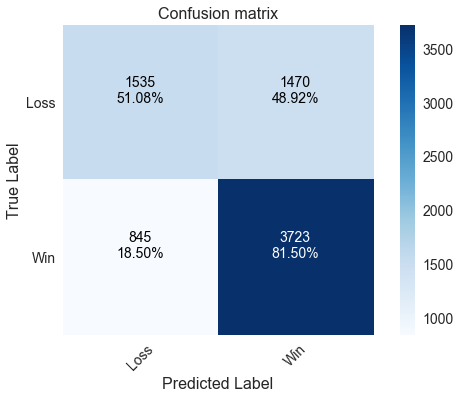

____________________________________________________
             precision    recall  f1-score   support

       Loss      0.645     0.511     0.570      3005
        Win      0.717     0.815     0.763      4568

avg / total      0.688     0.694     0.686      7573

Correctly predicted 69.43% of games


In [6]:
model = LogisticRegression()
model.fit(X_train[attributes], y_train)
models['Logistic Regression'] = model
pred = model.predict(X_test[attributes])
plot_confusion_matrix(confusion_matrix(y_test, pred), ['Loss', 'Win'])
print '_' * 52
print classification_report(y_test, pred, target_names=['Loss', 'Win'], digits=3)
print 'Correctly predicted %.2f%% of games' % (accuracy_score(y_test, pred) * 100)

# Support Vector Machine

One downside of using `LinearSVC` over `SVC` is that `LinearSVC` does not implement the `predict_proba` method, which is required to generate ROC and precision/recall curves. We can get around this by passing a trained `LinearSVC` model to a [`CalibratedClassifierCV`](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV) and specifying that the model is "prefit," meaning no cross validation is to be performed. The model does slightly better with home wins and worse with home losses compared to logistic regression, though the effect is minimal.

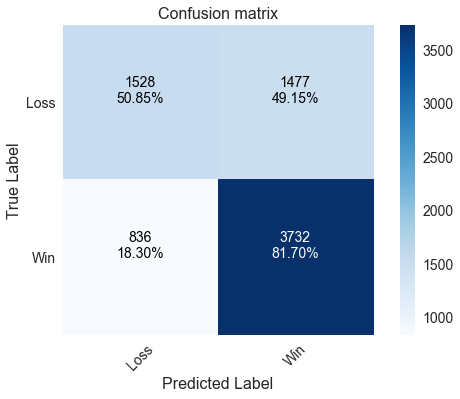

____________________________________________________
             precision    recall  f1-score   support

       Loss      0.646     0.508     0.569      3005
        Win      0.716     0.817     0.763      4568

avg / total      0.689     0.695     0.686      7573

Correctly predicted 69.46% of games


In [7]:
model = LinearSVC()
model.fit(X_train[attributes], y_train)
pred = model.predict(X_test[attributes])

model = CalibratedClassifierCV(model, cv='prefit')
model.fit(X_train[attributes], y_train)
models['Support Vector Machine'] = model

plot_confusion_matrix(confusion_matrix(y_test, pred), ['Loss', 'Win'])
print '_' * 52
print classification_report(y_test, pred, target_names=['Loss', 'Win'], digits=3)
print 'Correctly predicted %.2f%% of games' % (accuracy_score(y_test, pred) * 100)

# Random Forest

The random forest model does much worse than both the logistic regression and support vector machine models at predicting home wins. It correctly predicted less than 70% of games in which the home team won. It does slightly better than the previous two models at predicting home losses, though the model is less accurate overall by predicting about 62% of games correctly.

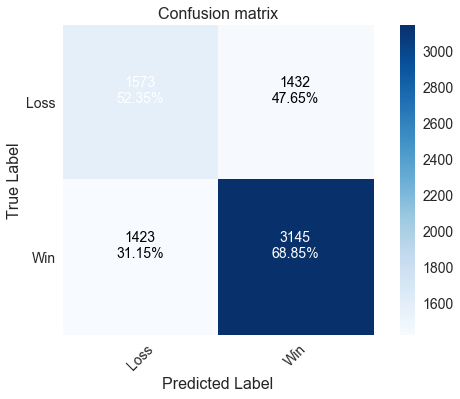

____________________________________________________
             precision    recall  f1-score   support

       Loss      0.525     0.523     0.524      3005
        Win      0.687     0.688     0.688      4568

avg / total      0.623     0.623     0.623      7573

Correctly predicted 62.30% of games


In [8]:
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train[attributes], y_train)
models['Random Forest'] = model
pred = model.predict(X_test[attributes])
plot_confusion_matrix(confusion_matrix(y_test, pred), ['Loss', 'Win'])
print '_' * 52
print classification_report(y_test, pred, target_names=['Loss', 'Win'], digits=3)
print 'Correctly predicted %.2f%% of games' % (accuracy_score(y_test, pred) * 100)

# Neural Network

The neural network has similar performance to both the logistic regression and support vector machine models.

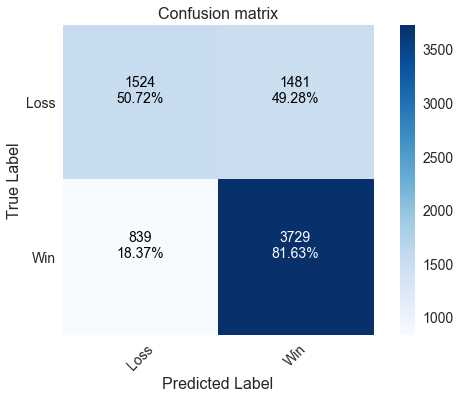

____________________________________________________
             precision    recall  f1-score   support

       Loss      0.645     0.507     0.568      3005
        Win      0.716     0.816     0.763      4568

avg / total      0.688     0.694     0.685      7573

Correctly predicted 69.36% of games


In [9]:
model = MLPClassifier(hidden_layer_sizes=5)
model.fit(X_train[attributes], y_train)
models['Neural Network'] = model
pred = model.predict(X_test[attributes])
plot_confusion_matrix(confusion_matrix(y_test, pred), ['Loss', 'Win'])
print '_' * 52
print classification_report(y_test, pred, target_names=['Loss', 'Win'], digits=3)
print 'Correctly predicted %.2f%% of games' % (accuracy_score(y_test, pred) * 100)

# Naive Bayes

A naive Bayes model (implemented with [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) is included as a comparison to the four previous models. It performs the best with home wins by correctly predicting over 82% of those games, but actually performs the worst at predicting home losses where it is no better than a coin flip.

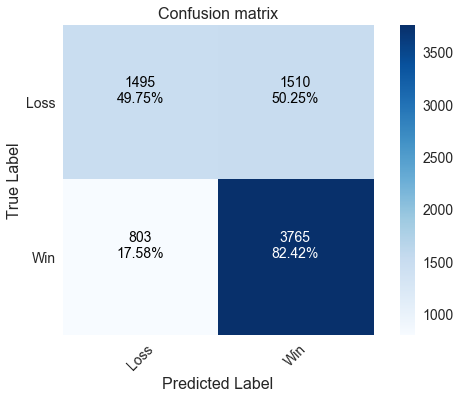

____________________________________________________
             precision    recall  f1-score   support

       Loss      0.651     0.498     0.564      3005
        Win      0.714     0.824     0.765      4568

avg / total      0.689     0.695     0.685      7573

Correctly predicted 69.46% of games


In [10]:
model = GaussianNB()
model.fit(X_train[attributes], y_train)
models['Naive Bayes'] = model
pred = model.predict(X_test[attributes])
plot_confusion_matrix(confusion_matrix(y_test, pred), ['Loss', 'Win'])
print '_' * 52
print classification_report(y_test, pred, target_names=['Loss', 'Win'], digits=3)
print 'Correctly predicted %.2f%% of games' % (accuracy_score(y_test, pred) * 100)

# Model Comparison

The following function plots ROC and precision/recall curves similar to the `cross_val_curves` function from the [feature selection](feature-selection.md) page, but does not permit cross validation.

In [11]:
def plot_performance_curves(models, X, y):
    plt.figure(figsize=(16, 6))
    
    for label, model in models.items():
        prob = model.predict_proba(X)
        
        # Plot ROC curve
        ax = plt.subplot(121)
        fpr, tpr, thresholds = roc_curve(y, prob[:, 1])
        roc_auc = roc_auc_score(y, prob[:, 1])
        ax.plot(fpr, tpr, label='%s (Area = %0.2f)' % (label, roc_auc))
        
        # Plot precision/recall curve
        ax = plt.subplot(122)
        precision, recall, thresholds = precision_recall_curve(y, prob[:, 1])
        pr_auc = average_precision_score(y, prob[:, 1])
        ax.plot(recall, precision, label='%s (Area = %0.2f)' % (label, pr_auc))
        
    # Label axes and add legend
    ax = plt.subplot(121)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    
    ax = plt.subplot(122)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend()
    ax.set_ylim(0.4)
    
    plt.show()

The plots below compare ROC and precision/recall curves for the five models evaluated above. The logistic regression, support vector machine, neural network, and naive bayes curves are nearly identical, which is to be expected given how similar their performance metrics were. The random forest model certainly sticks out with dramatically lower areas under both curves. There is an interesting discontinuity in the precision/recall curve at a recall of around 0.25.

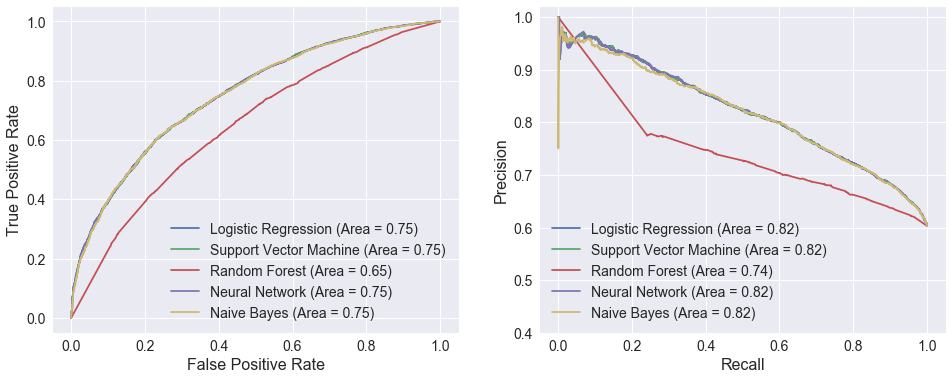

In [12]:
plot_performance_curves(models, X_test[attributes], y_test)